# 🔍 Projekt: Ágens fejlesztése a dohányzás, COVID-19 és szív- és érrendszeri betegségek kutatására
## Haldó NLP kurzus – Jupyter notebook
Ebben a projektben egy olyan intelligens ágenst fejlesztünk, amely a **CORD-19** adatbázis tudományos cikkeit használja fel annak vizsgálatára, hogy milyen kapcsolat van:

- a **dohányzás**,
- a **COVID-19** és
- a **szív- és érrendszeri betegségek** között.

A rendszer képes lesz:
- válaszolni természetes nyelvű kérdésekre ezekről a témákról,
- forráshivatkozással megjelölni az eredeti cikkeket.

A projekt célja, hogy megmutassuk, hogyan lehet modern **nyelvi modelleket**, **vektortárolókat** és **retrieval-alapú QA rendszereket** kombinálni egy hasznos orvosi kutatási ágens megépítéséhez.


In [1]:
!pip install matplotlib-venn

In [2]:
# Data handling
import os
import json
import pandas as pd
import numpy as np

# NLP tools
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# Vector search
import faiss

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Misc
from tqdm import tqdm
tqdm.pandas()

# For QA
from transformers import pipeline

base_path = "./"
#base_path = "/content/drive/MyDrive/Projektmunka Smoking and COVID19"
os.chdir(base_path)

In [3]:
# Példa: feltételezzük, hogy a CORD-19 metaadat fájl itt található
meta_path = "metadata.csv"

# Beolvassuk az első néhány ezer sort (memória miatt)
df = pd.read_csv(meta_path, low_memory=False)
df = df.head(5000)

# Nézzük meg az első néhány sort
df[["title", "abstract", "authors", "journal"]].head()


,title,abstract,authors,journal
0,Clinical features of culture-proven Mycoplasma...,OBJECTIVE: This retrospective chart review des...,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis
1,Nitric oxide: a pro-inflammatory mediator in l...,Inflammatory diseases of the respiratory tract...,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res
2,Surfactant protein-D and pulmonary host defense,Surfactant protein-D (SP-D) participates in th...,"Crouch, Erika C",Respir Res
3,Role of endothelin-1 in lung disease,Endothelin-1 (ET-1) is a 21 amino acid peptide...,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res
4,Gene expression in epithelial cells in respons...,Respiratory syncytial virus (RSV) and pneumoni...,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res


In [4]:
# Combine title and abstract for better context
def combine_text(row):
    title = str(row["title"]) if pd.notnull(row["title"]) else ""
    abstract = str(row["abstract"]) if pd.notnull(row["abstract"]) else ""
    return title.strip() + ". " + abstract.strip()

df["text"] = df.apply(combine_text, axis=1)

# Távolítsuk el azokat a sorokat, ahol nincs szöveg
df = df[df["text"].str.len() > 50].reset_index(drop=True)

# Ellenőrizzük a változást
df["text"].head(3).values


array(['Clinical features of culture-proven Mycoplasma pneumoniae infections at King Abdulaziz University Hospital, Jeddah, Saudi Arabia. OBJECTIVE: This retrospective chart review describes the epidemiology and clinical features of 40 patients with culture-proven Mycoplasma pneumoniae infections at King Abdulaziz University Hospital, Jeddah, Saudi Arabia. METHODS: Patients with positive M. pneumoniae cultures from respiratory specimens from January 1997 through December 1998 were identified through the Microbiology records. Charts of patients were reviewed. RESULTS: 40 patients were identified, 33 (82.5%) of whom required admission. Most infections (92.5%) were community-acquired. The infection affected all age groups but was most common in infants (32.5%) and pre-school children (22.5%). It occurred year-round but was most common in the fall (35%) and spring (30%). More than three-quarters of patients (77.5%) had comorbidities. Twenty-four isolates (60%) were associated with pneumoni

In [5]:
import re

def clean_text(text):
    text = re.sub(r"\s+", " ", text)  # multiple spaces
    text = re.sub(r"\[[^\]]*\]", "", text)  # citations like [1], [2]
    text = text.strip()
    return text

df["clean_text"] = df["text"].apply(clean_text)

# Nézzük meg a tisztított szövegeket
df["clean_text"].head(3).values


array(['Clinical features of culture-proven Mycoplasma pneumoniae infections at King Abdulaziz University Hospital, Jeddah, Saudi Arabia. OBJECTIVE: This retrospective chart review describes the epidemiology and clinical features of 40 patients with culture-proven Mycoplasma pneumoniae infections at King Abdulaziz University Hospital, Jeddah, Saudi Arabia. METHODS: Patients with positive M. pneumoniae cultures from respiratory specimens from January 1997 through December 1998 were identified through the Microbiology records. Charts of patients were reviewed. RESULTS: 40 patients were identified, 33 (82.5%) of whom required admission. Most infections (92.5%) were community-acquired. The infection affected all age groups but was most common in infants (32.5%) and pre-school children (22.5%). It occurred year-round but was most common in the fall (35%) and spring (30%). More than three-quarters of patients (77.5%) had comorbidities. Twenty-four isolates (60%) were associated with pneumoni

In [6]:
# Kulcsszavak meghatározása
keywords = {
    "dohányzás": ["smoking", "smoker", "smoke", "ecigarett", "cigarett",  "tobacco", "cigarette", "nicotine",
    "vaping", "vape", "e-cigarette", "smoker", "cigar", "weed", "marijuana"],
    "cardio": ["cardiovascular", "heart disease", "hypertension", "stroke"]
}

# Kulcsszó szűrés
def contains_keyword(text, keyword_list):
    text = text.lower()
    return any(keyword in text for keyword in keyword_list)

df["has_smoking"] = df["clean_text"].apply(lambda x: contains_keyword(x, keywords["dohányzás"]))
df["has_cardio"] = df["clean_text"].apply(lambda x: contains_keyword(x, keywords["cardio"]))

# Dokumentumok száma kategóriánként
df[["has_smoking", "has_cardio"]].sum()


has_smoking     34
has_cardio     111
dtype: int64

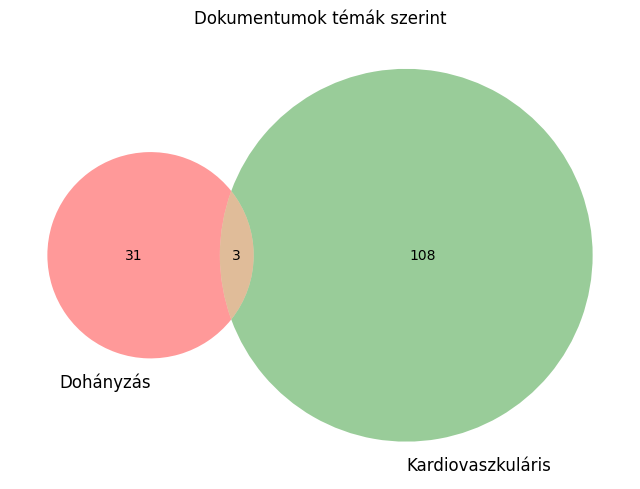

In [7]:
import matplotlib_venn as venn
import matplotlib.pyplot as plt

# Create set indices
set1 = set(df[df["has_smoking"]].index)
set2 = set(df[df["has_cardio"]].index)

# Venn-diagram halmaz metszetéről
plt.figure(figsize=(8, 6))
venn.venn2([set1, set2], set_labels=("Dohányzás", "Kardiovaszkuláris"))
plt.title("Dokumentumok témák szerint")
plt.show()


In [8]:
from sentence_transformers import SentenceTransformer

# Használjunk egy könnyű modellt, ami elfér 6GB GPU-n
model_name = "sentence-transformers/all-MiniLM-L6-v2"
model = SentenceTransformer(model_name)

# Csak azokat a szövegeket vektorizáljuk, amik legalább egy témát érintenek
df_filtered = df[df[["has_smoking", "has_cardio"]].any(axis=1)].reset_index(drop=True)

# Limitáljuk az adatok számát tesztelésre
texts = df_filtered["clean_text"].tolist()

# Embed texts
embeddings = model.encode(texts, show_progress_bar=True, convert_to_numpy=True)


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

In [9]:
import faiss

# Define FAISS index
embedding_dim = embeddings.shape[1]
index = faiss.IndexFlatL2(embedding_dim)
index.add(embeddings)

# Mentjük a dataframe-et is az index mellé, hogy a találatokat vissza tudjuk keresni
docs = df_filtered.reset_index(drop=True)


In [10]:
def search_similar_documents(query, top_k=5):
    query_embedding = model.encode([query])
    D, I = index.search(query_embedding, top_k)
    results = docs.iloc[I[0]].copy()
    results["score"] = D[0]
    return results

# Példakérdés
query = "Does smoking increase the risk of severe COVID-19?"
top_docs = search_similar_documents(query)
top_docs[["title", "score"]]


,title,score
1,Relevance of human metapneumovirus in exacerba...,1.155316
73,Th17 profile in COPD exacerbations,1.218824
81,Estimates of global research productivity in u...,1.223819
52,Imbalance of Th17/Tregs in rats with smoke inh...,1.277529
2,Public awareness of risk factors for cancer am...,1.280809


In [11]:
# Kérdés-válasz pipeline
qa_pipeline = pipeline("question-answering", model="deepset/roberta-base-squad2")

# Az első dokumentumból próbálunk választ adni
context = top_docs.iloc[0]["clean_text"]
answer = qa_pipeline(question=query, context=context)

print("Kérdés:", query)
print("Válasz:", answer["answer"])
print("\nForrás cím:", top_docs.iloc[0]["title"])


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/496M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/79.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

Device set to use cuda:0


Kérdés: Does smoking increase the risk of severe COVID-19?
Válasz: quantitative real-time RT-PCR

Forrás cím: Relevance of human metapneumovirus in exacerbations of COPD
